# ProSmart Graph Hackathon 2022 - Provider Profiling Using Synthea Graph DB and Advanced Graph Neural Network Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyTigerGraph as tg
import torch
from sklearn import preprocessing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import pair_confusion_matrix

In [2]:
import torch.nn.functional as F
from torch.optim import Adam
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import jaccard_score
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import ARGVA, GCNConv
import matplotlib.cm as cm
import time
from sklearn.manifold import TSNE

Connect to Local Synthea DB. Please refer following link on how to create Synthea DB. 

Its open source please follow the link below to create Synthea on Tigergraph

https://github.com/TigerGraph-DevLabs/Synthea-Medgraph

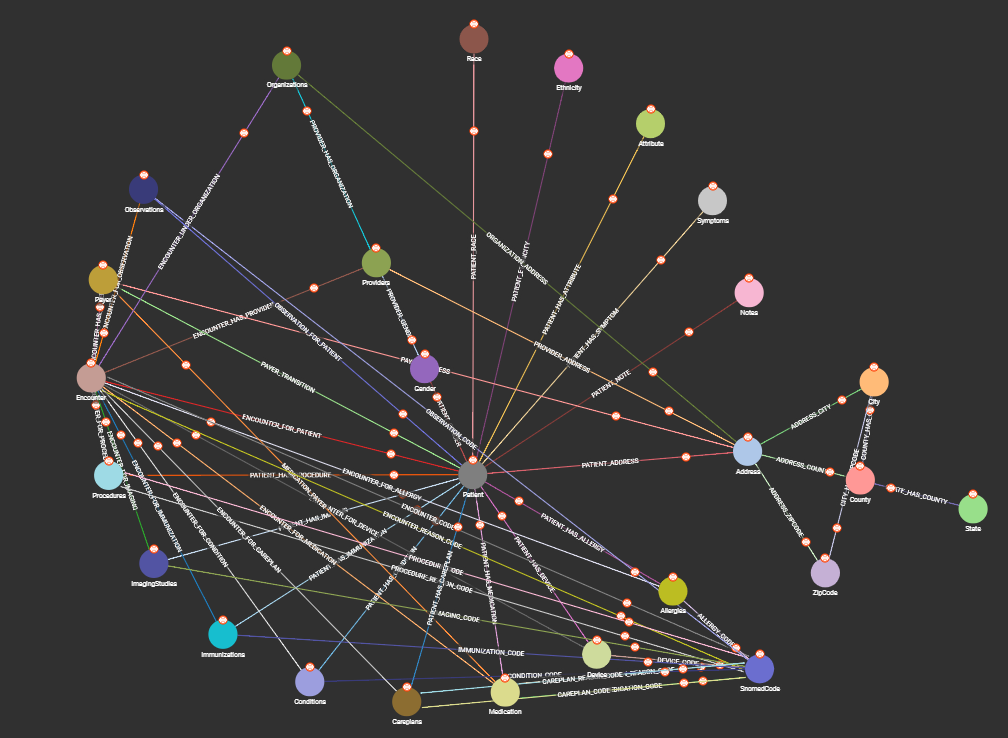

In [3]:
conn = tg.TigerGraphConnection(host='http://localhost', username='tigergraph', password='tigergraph',graphname='MedGraph')

In [4]:
le = preprocessing.LabelEncoder()

# Load Vertices in Python Environment

Patient Vertex

In [5]:
patient = conn.getVertexDataframe("Patient")
print(patient.shape[0])
patient.head(2)

496


,v_id,patient_id,lastName,firstName,maiden,birthday,ssn,license,passport,healthcareExpense,healthcareCoverage,suffix,prefix,maritalStatus,birthplace
0,7a4c97cd-0f8f-4654-9130-c49c7fd6144c,7a4c97cd-0f8f-4654-9130-c49c7fd6144c,Adams,Joey,,2014-11-02 00:00:00,999-89-1716,,,17240.00,2390.52,,,,Alexandria Kentucky US
1,923bffd4-22ce-466f-b584-bf8600bf450a,923bffd4-22ce-466f-b584-bf8600bf450a,Rocha,Ricardo,,1956-03-30 00:00:00,999-20-5689,S99987406,X50055024X,1398459.59,69890.74,,Mr.,S,Panama City Panama PA


Medication Vertex

In [6]:
medication = conn.getVertexDataframe("Medication")
print(medication.shape[0])
medication.head(2)

20069


,v_id,medication_id,medication_code,description,startDate,endDate,baseCost,payerCoverage,dispenses,totalCost
0,20049,20049,197361,Amlodipine 5 MG Oral Tablet,2015-02-07 13:57:18,2016-02-13 13:57:18,6.84,0.0,12,82.08
1,20030,20030,309362,Clopidogrel 75 MG Oral Tablet,2011-01-15 13:57:18,2012-01-21 13:57:18,19.40,0.0,12,232.80


In [7]:
symptom = conn.getVertexDataframe("Symptoms")
print(symptom.shape[0])
symptom.head(2)

63462


,v_id,symptom_id,symptom,symptomValue,pathology
0,66895,66895,Sinus Pain,55,Viral sinusitis (disorder)
1,66867,66867,Fatigue,33,Acute bronchitis (disorder)


In [8]:
ethnicity = conn.getVertexDataframe("Ethnicity")
print(ethnicity.shape[0])
ethnicity.head(5)

2


,v_id,ethnicity_id
0,nonhispanic,nonhispanic
1,hispanic,hispanic


In [9]:
careplans = conn.getVertexDataframe("Careplans")
print(careplans.shape[0])
careplans.head(2)

3949


,v_id,careplan_id,description,startDate,endDate
0,63c11b08-c0f9-4a14-a636-8c930d2e8fd6,63c11b08-c0f9-4a14-a636-8c930d2e8fd6,Head injury rehabilitation,1970-12-24 00:00:00,1971-01-23 00:00:00
1,faf38688-9901-4e9d-9971-368f45428303,faf38688-9901-4e9d-9971-368f45428303,Respiratory therapy,1985-11-18 00:00:00,1985-11-25 00:00:00


In [10]:
conditions = conn.getVertexDataframe("Conditions")
print(conditions.shape[0])
conditions.head(2)

10129


,v_id,condition_id,condition_code,description,startDate,endDate
0,10008,10008,59621000,Hypertension,1974-11-05 00:00:00,1970-01-01 00:00:00
1,9913,9913,15777000,Prediabetes,1997-08-01 00:00:00,1970-01-01 00:00:00


In [11]:
gender = conn.getVertexDataframe("Gender")
print(gender.shape[0])
gender.head(2)

2


,v_id,gender_id
0,M,M
1,F,F


In [12]:
race = conn.getVertexDataframe("Race")
print(race.shape[0])
race.head(2)

5


,v_id,race_id
0,white,white
1,asian,asian


In [13]:
attribute = conn.getVertexDataframe("Attribute")
print(attribute.shape[0])
attribute.head(2)

20


,v_id,label,attributeValue
0,Alcoholic,Alcoholic,1
1,No Insurance,No Insurance,0


In [15]:
# observation = conn.getVertexDataframe("Observations")
# print(observation.shape[0])
# observation.head(2)

In [ ]:
observation.to_csv('observation.csv')

In [14]:
observation=pd.read_csv('observation.csv')
observation.head(2)

,Unnamed: 0,v_id,observation_id,dateOfObservation,observation_code,description,obsValue,units
0,0,406779,406779,1964-07-20 13:57:18,QOLS,QOLS,1.0,{score}
1,1,406644,406644,2018-02-24 13:57:18,2085-9,High Density Lipoprotein Cholesterol,62.3,mg/dL


# Load Edges in Python Environment

PATIENT_HAS_MEDICATION

In [ ]:
patient_has_medication = pd.DataFrame()
for i in medication.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Medication', sourceVertexId = i, edgeType = 'PATIENT_HAS_MEDICATION')
    patient_has_medication = pd.concat([edges, patient_has_medication],  ignore_index=True)

In [ ]:
print(patient_has_medication.shape)
patient_has_medication.head(2)

In [22]:
patient_has_medication.to_csv('patient_has_medication.csv')

In [15]:
patient_has_medication = pd.read_csv('patient_has_medication.csv')
patient_has_medication=patient_has_medication.drop('Unnamed: 0', axis=1)
patient_has_medication.head(2)

,from_type,from_id,to_type,to_id
0,Medication,29,Patient,3a103735-1908-45ca-8db7-b36ee66e6475
1,Medication,65,Patient,0ce21d8a-a59a-4c85-88c3-3bacdbb895f8


PATIENT_HAS_SYMPTOM

In [76]:
patient_has_symptom = pd.DataFrame()
for i in patient.v_id.values:
    try:
        edges = conn.getEdgesDataframe(sourceVertexType = 'Patient', sourceVertexId = i, edgeType = 'PATIENT_HAS_SYMPTOM')
        patient_has_symptom = pd.concat([edges, patient_has_symptom],  ignore_index=True)
    except:
        continue

In [78]:
print(patient_has_symptom.shape)
patient_has_symptom.head(2)

(15230, 6)


,from_type,from_id,to_type,to_id,ageBegin,ageEnd
0,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Symptoms,47807,57,0
1,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Symptoms,47871,66,0


In [ ]:
patient_has_symptom.to_csv('patient_has_symptom.csv')

In [16]:
patient_has_symptom = pd.read_csv('patient_has_symptom.csv')
patient_has_symptom=patient_has_symptom.drop('Unnamed: 0', axis=1)
patient_has_symptom.head(2)

,from_type,from_id,to_type,to_id,ageBegin,ageEnd
0,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Symptoms,47807,57,0
1,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Symptoms,47871,66,0


PATIENT_HAS_CAREPLAN

In [83]:
patient_has_careplans = pd.DataFrame()
for i in careplans.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Careplans', sourceVertexId = i, edgeType = 'PATIENT_HAS_CAREPLAN')
    patient_has_careplans = pd.concat([edges, patient_has_careplans],  ignore_index=True)

In [84]:
print(patient_has_careplans.shape)
patient_has_careplans.head(2)

(3949, 4)


,from_type,from_id,to_type,to_id
0,Careplans,cd8b5a5f-7b3f-4a78-90f5-b16f48434755,Patient,d81bcae2-13da-4d05-ac8c-64e40d619191
1,Careplans,d6867f88-8bb8-4d99-b7c2-6eefba18b735,Patient,f5b8c724-df3f-407d-ace7-787fac641ce5


In [ ]:
patient_has_careplans.to_csv('patient_has_careplans.csv')

In [17]:
patient_has_careplans = pd.read_csv('patient_has_careplans.csv')
patient_has_careplans=patient_has_careplans.drop('Unnamed: 0', axis=1)
patient_has_careplans.head(2)

,from_type,from_id,to_type,to_id
0,Careplans,cd8b5a5f-7b3f-4a78-90f5-b16f48434755,Patient,d81bcae2-13da-4d05-ac8c-64e40d619191
1,Careplans,d6867f88-8bb8-4d99-b7c2-6eefba18b735,Patient,f5b8c724-df3f-407d-ace7-787fac641ce5


PATIENT_HAS_CONDITION

In [87]:
patient_has_condition = pd.DataFrame()
for i in conditions.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Conditions', sourceVertexId = i, edgeType = 'PATIENT_HAS_CONDITION')
    patient_has_condition = pd.concat([edges, patient_has_condition],  ignore_index=True)

In [88]:
print(patient_has_condition.shape)
patient_has_condition.head(2)

(10129, 4)


,from_type,from_id,to_type,to_id
0,Conditions,7436,Patient,62027462-5ac8-4031-a997-1311ef242b16
1,Conditions,8304,Patient,972a17e6-1178-489b-8814-61f709197643


In [ ]:
patient_has_condition.to_csv('patient_has_condition.csv')

In [18]:
patient_has_condition = pd.read_csv('patient_has_condition.csv')
patient_has_condition=patient_has_condition.drop('Unnamed: 0', axis=1)
patient_has_condition.head(2)

,from_type,from_id,to_type,to_id
0,Conditions,7436,Patient,62027462-5ac8-4031-a997-1311ef242b16
1,Conditions,8304,Patient,972a17e6-1178-489b-8814-61f709197643


OBSERVATION_FOR_PATIENT

In [23]:
observation.shape

(406834, 7)

In [20]:
observation_for_patient = pd.DataFrame()

In [29]:
from datetime import datetime
j=0
for i in observation.v_id.values[:300000]:
    j=j+1
    dt = datetime.now()
    if (j%2000==0):
        print(j)
        print("Date and time is:", dt)
    edges = conn.getEdgesDataframe(sourceVertexType = 'Observations', sourceVertexId = i, edgeType = 'OBSERVATION_FOR_PATIENT', limit=3)
    observation_for_patient = pd.concat([edges, observation_for_patient],  ignore_index=True)

2000
Date and time is: 2022-08-26 18:07:18.550089
4000
Date and time is: 2022-08-26 18:08:18.018154
6000
Date and time is: 2022-08-26 18:09:04.289186
8000
Date and time is: 2022-08-26 18:10:05.217608
10000
Date and time is: 2022-08-26 18:10:53.797347
12000
Date and time is: 2022-08-26 18:11:42.934772
14000
Date and time is: 2022-08-26 18:12:35.058212
16000
Date and time is: 2022-08-26 18:13:24.589700
18000
Date and time is: 2022-08-26 18:14:12.506668
20000
Date and time is: 2022-08-26 18:14:57.072939
22000
Date and time is: 2022-08-26 18:15:57.060119
24000
Date and time is: 2022-08-26 18:16:56.942410
26000
Date and time is: 2022-08-26 18:17:45.634785
28000
Date and time is: 2022-08-26 18:18:35.425180
30000
Date and time is: 2022-08-26 18:19:24.218146
32000
Date and time is: 2022-08-26 18:20:17.202126
34000
Date and time is: 2022-08-26 18:21:07.329727
36000
Date and time is: 2022-08-26 18:21:56.126472
38000
Date and time is: 2022-08-26 18:22:48.867323
40000
Date and time is: 2022-08-26 

In [31]:
print(observation_for_patient.shape)
observation_for_patient.head(2)

(300000, 4)


,from_type,from_id,to_type,to_id
0,Observations,339028,Patient,8694905b-9e73-4181-b0e3-2e28dd7913e6
1,Observations,371465,Patient,b6ef40ea-479e-4bdb-945c-f7aeca65067f


In [32]:
observation_for_patient.to_csv('observation_for_pateint.csv')

In [46]:
observation_for_patient = pd.read_csv('observation_for_pateint.csv')
observation_for_patient=observation_for_patient.drop('Unnamed: 0', axis=1)
observation_for_patient.head(2)

,from_type,from_id,to_type,to_id
0,Observations,339028,Patient,8694905b-9e73-4181-b0e3-2e28dd7913e6
1,Observations,371465,Patient,b6ef40ea-479e-4bdb-945c-f7aeca65067f


In [14]:
from datetime import datetime
j=300000
dt = datetime.now()
print("Date and time is:", dt)
for i in observation.v_id.values[300001:]:
    j=j+1
    dt = datetime.now()
    if (j%2000==0):
        print(j)
        print("Date and time is:", dt)
    edges = conn.getEdgesDataframe(sourceVertexType = 'Observations', sourceVertexId = i, edgeType = 'OBSERVATION_FOR_PATIENT', limit=3)
    observation_for_patient = pd.concat([edges, observation_for_patient],  ignore_index=True)

Date and time is: 2022-08-26 22:19:36.555589
302000
Date and time is: 2022-08-26 22:21:32.651341
304000
Date and time is: 2022-08-26 22:23:28.145756
306000
Date and time is: 2022-08-26 22:25:02.625650
308000
Date and time is: 2022-08-26 22:26:15.542983
310000
Date and time is: 2022-08-26 22:27:32.489195
312000
Date and time is: 2022-08-26 22:29:00.829041
314000
Date and time is: 2022-08-26 22:30:19.228435
316000
Date and time is: 2022-08-26 22:31:32.917834
318000
Date and time is: 2022-08-26 22:32:50.114852
320000
Date and time is: 2022-08-26 22:34:03.784505
322000
Date and time is: 2022-08-26 22:35:18.916201
324000
Date and time is: 2022-08-26 22:36:35.489264
326000
Date and time is: 2022-08-26 22:37:51.489170
328000
Date and time is: 2022-08-26 22:39:08.926398
330000
Date and time is: 2022-08-26 22:40:24.527974
332000
Date and time is: 2022-08-26 22:41:43.774376
334000
Date and time is: 2022-08-26 22:43:06.239584
336000
Date and time is: 2022-08-26 22:44:24.138353
338000
Date and tim

In [15]:
print(observation_for_pateint.shape)
observation_for_pateint.head(2)

(406833, 4)


,from_type,from_id,to_type,to_id
0,Observations,65,Patient,66d12724-5fa3-49cf-97b1-a491f2de7dac
1,Observations,159986,Patient,6078f0d8-1018-4b58-b908-f027f404eb28


In [27]:
# observation_for_pateint.to_csv('observation_for_pateint_all.csv')

In [19]:
observation_for_patient = pd.read_csv('observation_for_pateint_all.csv')
observation_for_patient=observation_for_patient.drop('Unnamed: 0', axis=1)
observation_for_patient.head(2)

,from_type,from_id,to_type,to_id
0,Observations,65,Patient,66d12724-5fa3-49cf-97b1-a491f2de7dac
1,Observations,159986,Patient,6078f0d8-1018-4b58-b908-f027f404eb28


PATIENT_HAS_ATTRIBUTE

In [89]:
patient_has_attribute = pd.DataFrame()
for i in patient.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Patient', sourceVertexId = i, edgeType = 'PATIENT_HAS_ATTRIBUTE')
    patient_has_attribute = pd.concat([edges, patient_has_attribute],  ignore_index=True)

In [90]:
print(patient_has_attribute.shape)
patient_has_attribute.head(2)

(9920, 4)


,from_type,from_id,to_type,to_id
0,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Attribute,Opioid Addiction
1,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Attribute,Never Smoked


In [91]:
patient_has_attribute.to_csv('patient_has_attribute.csv')

In [20]:
patient_has_attribute = pd.read_csv('patient_has_attribute.csv')
patient_has_attribute=patient_has_attribute.drop('Unnamed: 0', axis=1)
patient_has_attribute.head(2)

,from_type,from_id,to_type,to_id
0,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Attribute,Opioid Addiction
1,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Attribute,Never Smoked


PATIENT_RACE

In [102]:
patient_race = pd.DataFrame()
for i in patient.v_id.values:
    edges = conn.getEdgesDataframe(sourceVertexType = 'Patient', sourceVertexId = i, edgeType = 'PATIENT_RACE')
    patient_race = pd.concat([edges, patient_race],  ignore_index=True)

In [103]:
print(patient_race.shape)
patient_race.head(2)

(496, 4)


,from_type,from_id,to_type,to_id
0,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Race,white
1,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Race,white


In [104]:
patient_race.to_csv('patient_race.csv')

In [21]:
patient_race = pd.read_csv('patient_race.csv')
patient_race=patient_race.drop('Unnamed: 0', axis=1)
patient_race.head(2)

,from_type,from_id,to_type,to_id
0,Patient,bffa035b-ccfa-4730-8858-96a4fc871d6b,Race,white
1,Patient,db94b393-0150-4619-bc83-00a7b57415c2,Race,white


# mappings for pytorch-geometric data object

In [22]:
a=[]
b=[]
for i,index in enumerate(medication.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
medication_mapping = dict(zip(b, a.T)) 

In [23]:
a=[]
b=[]
for i,index in enumerate(patient.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
patient_mapping = dict(zip(b, a.T)) 

In [24]:
a=[]
b=[]
for i,index in enumerate(conditions.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
condition_mapping  = dict(zip(b, a.T)) 

In [25]:
a=[]
b=[]
for i,index in enumerate(symptom.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
symptom_mapping = dict(zip(b, a.T)) 

In [26]:
a=[]
b=[]
for i,index in enumerate(ethnicity.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
ethnicity_mapping = dict(zip(b, a.T)) 

In [27]:
a=[]
b=[]
for i,index in enumerate(careplans.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
careplans_mapping = dict(zip(b, a.T)) 

In [28]:
a=[]
b=[]
for i,index in enumerate(observation.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
observations_mapping = dict(zip(b, a.T)) 

In [29]:
a=[]
b=[]
for i,index in enumerate(attribute.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
attribute_mapping = dict(zip(b, a.T)) 

In [30]:
a=[]
b=[]
for i,index in enumerate(race.index.unique()):
    a.append(i)
    b.append(index)
a = np.asarray(a)
b = np.asarray(b)
race_mapping = dict(zip(b, a.T)) 

In [31]:
def load_edge_csv(edge_df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                   **kwargs):
    df = edge_df
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    return edge_index

# Tensorize the Nodes

In [32]:
medication['medication_id'] = pd.to_numeric(medication['medication_id'])
medication['v_id'] = pd.to_numeric(medication['v_id'])
le =le.fit(medication['medication_id'])
medication['medication_id'] =  le.transform(medication['medication_id'])
le =le.fit(medication['medication_code'])
medication['medication_code'] =  le.transform(medication['medication_code'])
medication[['medication_code','description']].to_csv('medication.csv')
medicationmap = medication [['v_id','medication_id']]
medicationmap = dict(zip(medicationmap.v_id, medicationmap.medication_id))
medication = medication[['medication_id','medication_code','baseCost','payerCoverage','dispenses','totalCost']]
medication = medication.set_index('medication_id')
medication.head()

,medication_code,baseCost,payerCoverage,dispenses,totalCost
medication_id,,,,,
20048,46,6.84,0.0,12,82.08
20029,71,19.40,0.0,12,232.80
19600,10,291.03,0.0,1,291.03
19507,10,398.55,0.0,1,398.55
19403,103,1200.00,0.0,12,14400.00


In [33]:
le =le.fit(patient['patient_id'])
patient['patient_id'] =  le.transform(patient['patient_id'])
patientmap = patient [['v_id','patient_id']]
patientmap = dict(zip(patientmap.v_id,patientmap.patient_id))
patient = patient [['patient_id','healthcareExpense','healthcareCoverage','birthplace']]
patient = patient.set_index('patient_id')
le =le.fit(patient['birthplace'])
patient['birthplace'] =  le.transform(patient['birthplace'])
patient.head(2)

,healthcareExpense,healthcareCoverage,birthplace
patient_id,,,
232,17240.00,2390.52,3
279,1398459.59,69890.74,275


In [34]:
le =le.fit(symptom['symptom_id'])
symptom['symptom_id'] =  le.transform(symptom['symptom_id'])
symptommap = symptom [['v_id','symptom_id']]
symptommap = dict(zip(symptommap.v_id,symptommap.symptom_id))
symptom = symptom [['symptom_id','symptom','symptomValue','pathology']]
symptom = symptom.set_index('symptom_id')
le =le.fit(symptom['symptom'])
symptom['symptom'] =  le.transform(symptom['symptom'])
le =le.fit(symptom['pathology'])
symptom['pathology'] =  le.transform(symptom['pathology'])
symptom.head(2)

,symptom,symptomValue,pathology
symptom_id,,,
52316,62,55,49
52285,25,33,3


In [35]:
le =le.fit(ethnicity['ethnicity_id'])
ethnicity['ethnicity_id'] =  le.transform(ethnicity['ethnicity_id'])
ethnicitymap = ethnicity[['v_id','ethnicity_id']]
ethnicitymap = dict(zip(ethnicitymap.v_id,ethnicitymap.ethnicity_id))
ethnicity['ethnicity_id1'] = ethnicity['ethnicity_id']
ethnicity= ethnicity[['ethnicity_id','ethnicity_id1']]
ethnicity = ethnicity.set_index('ethnicity_id')
le =le.fit(ethnicity['ethnicity_id1'])
ethnicity['ethnicity_id1'] =  le.transform(ethnicity['ethnicity_id1'])

In [36]:
ethnicity.head(2)

,ethnicity_id1
ethnicity_id,
1,1
0,0


In [37]:
le =le.fit(careplans['careplan_id'])
careplans['careplan_id'] =  le.transform(careplans['careplan_id'])
careplansmap = careplans[['v_id','careplan_id']]
careplansmap = dict(zip(careplansmap.v_id,careplansmap.careplan_id))
careplans= careplans[['careplan_id','description']]
careplans = careplans.set_index('careplan_id')
le =le.fit(careplans['description'])
careplans['description'] =  le.transform(careplans['description'])
careplans.head(2)

,description
careplan_id,
1517,11
3869,25


In [38]:
le =le.fit(conditions['condition_id'])
conditions['condition_id'] =  le.transform(conditions['condition_id'])
conditionsmap = conditions[['v_id','condition_id']]
conditionsmap = dict(zip(conditionsmap.v_id,conditionsmap.condition_id))
conditions= conditions[['condition_id','condition_code','description']]
conditions = conditions.set_index('condition_id')

le =le.fit(conditions['condition_code'])
conditions['condition_code'] =  le.transform(conditions['condition_code'])

le =le.fit(conditions['description'])
conditions['description'] =  le.transform(conditions['description'])
conditions.head(2)

,condition_code,description
condition_id,,
12,95,60
10034,12,97


In [39]:
le =le.fit(gender['gender_id'])
gender['gender_id'] =  le.transform(gender['gender_id'])
gendermap = gender[['v_id','gender_id']]
gendermap = dict(zip(gendermap.v_id,gendermap.gender_id))
gender['gender_id1'] = gender['gender_id']
gender= gender[['gender_id','gender_id1']]
gender = gender.set_index('gender_id')
le =le.fit(gender['gender_id1'])
gender['gender_id1'] =  le.transform(gender['gender_id1'])
gender.head(2)

,gender_id1
gender_id,
1,1
0,0


In [40]:
le =le.fit(race['race_id'])
race['race_id'] =  le.transform(race['race_id'])
racemap = race[['v_id','race_id']]
racemap = dict(zip(racemap.v_id,racemap.race_id))
race['race_id1'] = race['race_id']
race= race[['race_id','race_id1']]
race = race.set_index('race_id')
le =le.fit(race['race_id1'])
race['race_id1'] =  le.transform(race['race_id1'])
race.head(2)

,race_id1
race_id,
4,4
0,0


In [41]:
attribute['attribute_id'] = attribute['v_id']
le =le.fit(attribute['attribute_id'])
attribute['attribute_id'] =  le.transform(attribute['attribute_id'])
attributemap = attribute[['v_id','attribute_id']]
attributemap = dict(zip(attributemap.v_id,attributemap.attribute_id))
attribute= attribute[['attribute_id','label']]
attribute = attribute.set_index('attribute_id')
le =le.fit(attribute['label'])
attribute['label'] =  le.transform(attribute['label'])
attribute.head(2)

,label
attribute_id,
0,0
15,15


In [42]:
observation['observation_id'] = observation['v_id']
le =le.fit(observation['observation_id'])
observation['observation_id'] =  le.transform(observation['observation_id'])
observationmap = observation[['v_id','observation_id']]
observationmap = dict(zip(observationmap.v_id,observationmap.observation_id))
observation= observation[['observation_id','observation_code', 'description', 'obsValue', 'units']]
observation = observation.set_index('observation_id')
le =le.fit(observation['observation_code'])
observation['observation_code'] =  le.transform(observation['observation_code'])
le =le.fit(observation['description'])
observation['description'] =  le.transform(observation['description'])
le =le.fit(observation['obsValue'])
observation['obsValue'] =  le.transform(observation['obsValue'])
le =le.fit(observation['units'])
observation['units'] =  le.transform(observation['units'])
observation.head(2)

,observation_code,description,obsValue,units
observation_id,,,,
406778,146,109,26,37
406643,18,62,4432,22


In [46]:
# observationmap

# Convert edge to Pytorch Tensors

In [111]:
# PATIENT_HAS_MEDICATION  sourceVertexType = 'Medication'
# PATIENT_HAS_SYMPTOM  sourceVertexType = 'Patient'
# PATIENT_HAS_CAREPLAN  sourceVertexType = 'Careplans'
# PATIENT_HAS_CONDITION  sourceVertexType = 'Conditions'
# OBSERVATION_FOR_PATIENT   sourceVertexType = 'Observations'
# PATIENT_HAS_ATTRIBUTE  sourceVertexType = 'Patient'
# PATIENT_RACE  sourceVertexType = 'Patient'

In [45]:
patient_has_medication = patient_has_medication.replace({'from_id' : medicationmap})
patient_has_medication = patient_has_medication.replace({'to_id' : patientmap})

In [46]:
patient_has_medication.to_csv('patient_has_medication1.csv')

In [47]:
src = [patient_mapping[index] for index in patient_has_medication['to_id']]
dst = [medication_mapping[index] for index in patient_has_medication['from_id']]
patient_has_medication_index = torch.tensor([src, dst],dtype=torch.long)
torch.save(patient_has_medication_index, 'patient_has_medication_index.pt')

In [43]:
patient_has_medication_index = torch.load('patient_has_medication_index.pt')
len(patient_has_medication_index[0])

20069

In [49]:
patient_has_symptom = patient_has_symptom.replace({'from_id' : patientmap})
patient_has_symptom = patient_has_symptom.replace({'to_id' : symptommap})
patient_has_symptom.head(2)

,from_type,from_id,to_type,to_id,ageBegin,ageEnd
0,Patient,427,Symptoms,47807,57,0
1,Patient,427,Symptoms,47871,66,0


In [50]:
np.max(list(symptom_mapping.keys()))

63461

In [51]:
src = [patient_mapping[index] for index in patient_has_symptom['from_id']]
dst = [symptom_mapping[index] for index in patient_has_symptom['to_id'] if index < 55420]

In [52]:
len(src), len(dst)

(15230, 12613)

In [53]:
patient_has_symptom_index = torch.tensor([src[:12613], dst],dtype=torch.long)
torch.save(patient_has_symptom_index, 'patient_has_symptom_index.pt')

In [44]:
patient_has_symptom_index = torch.load('patient_has_symptom_index.pt')
len(patient_has_symptom_index[0])

12613

In [55]:
patient_has_careplans.shape

(3949, 4)

In [56]:
patient_has_careplans = patient_has_careplans.replace({'from_id' : careplansmap})
patient_has_careplans = patient_has_careplans.replace({'to_id' : patientmap})
patient_has_careplans.head(2)

,from_type,from_id,to_type,to_id
0,Careplans,3169,Patient,420
1,Careplans,3310,Patient,475


In [57]:
src = [patient_mapping[index] for index in patient_has_careplans['to_id']]
dst = [careplans_mapping[index] for index in patient_has_careplans['from_id']]

In [58]:
patient_has_careplans_index = torch.tensor([src, dst],dtype=torch.long)
torch.save(patient_has_careplans_index, 'patient_has_careplans_index.pt')

In [45]:
patient_has_careplans_index = torch.load('patient_has_careplans_index.pt')
len(patient_has_careplans_index[0])

3949

In [60]:
patient_has_careplans.shape

(3949, 4)

In [61]:
patient_has_condition = patient_has_condition.replace({'from_id' : conditionsmap})
patient_has_condition = patient_has_condition.replace({'to_id' : patientmap})
patient_has_condition.head(2)

,from_type,from_id,to_type,to_id
0,Conditions,7436,Patient,193
1,Conditions,8304,Patient,290


In [62]:
patient_has_condition.shape

(10129, 4)

In [63]:
list(set(patient_has_condition.to_id.values))[76]

77

In [153]:
src = [patient_mapping[index] for index in patient_has_condition['to_id']]
dst = [condition_mapping[index] for index in patient_has_condition['from_id'] if index < 10128]

In [154]:
np.max((src)), len(set(src))

(495, 480)

In [155]:
patient_has_condition_index = torch.tensor([src[0:10127], dst[:10127]],dtype=torch.long)
torch.save(patient_has_condition_index, 'patient_has_condition_index.pt')

In [46]:
patient_has_condition_index = torch.load('patient_has_condition_index.pt')
len(patient_has_condition_index[0])

10127

In [157]:
patient_has_condition_index.shape

torch.Size([2, 10127])

In [64]:
[i for i in list(observationmap.keys()) if i ==397]

[397]

In [75]:
len(observationmap[1]

0

In [70]:
observation_for_patient[observation_for_patient.from_id ==396]

,from_type,from_id,to_type,to_id
43828,Observations,396,Patient,3bca02ec-b2d5-432c-96ad-932161f54cb4


observation_for_patient.replace({'from_id' : observationmap})
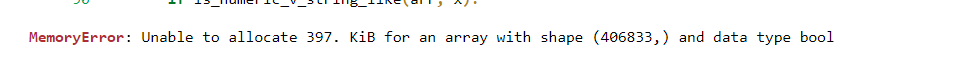


In [158]:
# observation_for_patient = observation_for_patient.replace({'from_id' : observationmap})
observation_for_patient = observation_for_patient.replace({'to_id' : patientmap})
print(observation_for_patient.shape)
observation_for_patient.head(2) 

(406833, 4)


,from_type,from_id,to_type,to_id
0,Observations,65,Patient,201
1,Observations,159986,Patient,189


In [204]:
observations_mapping[406834-1]

406833

In [205]:
src = [observations_mapping[index-1] for index in observation_for_patient['from_id']] # if index < 10129]
dst = [patient_mapping[index] for index in observation_for_patient['to_id']]

In [206]:
observation_for_patient_index = torch.tensor([src, dst],dtype=torch.long)
torch.save(observation_for_patient_index, 'observation_for_patient_index.pt')

In [47]:
observation_for_patient_index = torch.load('observation_for_patient_index.pt')
len(observation_for_patient_index[0])

406833

In [314]:
patient_has_attribute = patient_has_attribute.replace({'from_id' : patientmap})
patient_has_attribute = patient_has_attribute.replace({'to_id' : attributemap})
print(patient_has_attribute.shape)
patient_has_attribute.head(2) 

(9920, 4)


,from_type,from_id,to_type,to_id
0,Patient,363,Attribute,16
1,Patient,363,Attribute,14


In [315]:
src = [patient_mapping[index] for index in patient_has_attribute['from_id']] # if index < 10129]
dst = [attribute_mapping[index] for index in patient_has_attribute['to_id']]
patient_has_attribute_index = torch.tensor([src, dst],dtype=torch.long)

In [316]:
torch.save(patient_has_attribute_index, 'patient_has_attribute_index.pt')

In [48]:
patient_has_attribute_index = torch.load('patient_has_attribute_index.pt')
len(patient_has_attribute_index[0])

9920

In [318]:
patient_race = patient_race.replace({'from_id' : patientmap})
patient_race = patient_race.replace({'to_id' : racemap})
print(patient_race.shape)
patient_race.head(2) 

(496, 4)


,from_type,from_id,to_type,to_id
0,Patient,363,Race,4
1,Patient,427,Race,4


In [319]:
src = [patient_mapping[index] for index in patient_race['from_id']] # if index < 10129]
dst = [race_mapping[index] for index in patient_race['to_id']]
patient_race_index = torch.tensor([src, dst],dtype=torch.long)

In [320]:
torch.save(patient_race_index, 'patient_race_index.pt')

In [49]:
patient_race_index = torch.load('patient_race_index.pt')
len(patient_race_index[0])

496

# Heterogeneous Data i.e. Knowledge Graph embeddings

In [50]:
from torch_geometric.data import HeteroData
data = HeteroData()

In [51]:
data['patient'].x = torch.Tensor([patient.healthcareExpense.values, patient.healthcareCoverage.values,patient.birthplace.values]).t()
# data['patient'].x = torch.Tensor([pat.healthcareExpense.values, pat.healthcareCoverage.values,pat.birthplace.values]).t()
data['medication'].x = torch.Tensor([medication.medication_code.values, medication.baseCost.values, medication.payerCoverage.values, medication.dispenses.values, medication.totalCost.values]).t()
data['symptom'].x = torch.Tensor([symptom.symptom.values, symptom.symptomValue.values, symptom.pathology.values]).t()
data['ethnicity'].x = torch.Tensor([ethnicity.ethnicity_id1.values]).t()
data['careplans'].x = torch.Tensor([careplans.description.values]).t()
data['condition'].x = torch.Tensor([conditions.condition_code.values[:10128]]).t()
data['condition'].y = torch.Tensor([conditions.description.values[:10128]]).t().reshape(-1)
data['condition'].y = data['condition'].y.type(torch.LongTensor)

data['gender'].x = torch.Tensor([gender.gender_id1.values]).t()
data['race'].x = torch.Tensor([race.race_id1.values]).t()
data['attribute'].x = torch.Tensor([attribute.label.values]).t()
data['observation'].x = torch.Tensor([observation.observation_code.values, observation.description.values, observation.obsValue.values, observation.units.values]).t()

data['patient', 'has', 'medication'].edge_index = patient_has_medication_index
data['patient', 'has', 'symptom'].edge_index = patient_has_symptom_index
data['patient', 'has', 'careplans'].edge_index = patient_has_careplans_index
data['patient', 'has', 'condition'].edge_index = patient_has_condition_index
data['observation', 'for', 'patient'].edge_index = observation_for_patient_index
data['patient', 'has', 'attribute'].edge_index = patient_has_attribute_index
data['patient', 'has', 'race'].edge_index = patient_race_index


In [52]:
max(set(data['condition'].y.numpy()))

124

In [53]:
data

HeteroData(
  patient={ x=[496, 3] },
  medication={ x=[20069, 5] },
  symptom={ x=[63462, 3] },
  ethnicity={ x=[2, 1] },
  careplans={ x=[3949, 1] },
  condition={
    x=[10128, 1],
    y=[10128]
  },
  gender={ x=[2, 1] },
  race={ x=[5, 1] },
  attribute={ x=[20, 1] },
  observation={ x=[406834, 4] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (patient, has, symptom)={ edge_index=[2, 12613] },
  (patient, has, careplans)={ edge_index=[2, 3949] },
  (patient, has, condition)={ edge_index=[2, 10127] },
  (observation, for, patient)={ edge_index=[2, 406833] },
  (patient, has, attribute)={ edge_index=[2, 9920] },
  (patient, has, race)={ edge_index=[2, 496] }
)

In [54]:
data['condition'].y.numpy().reshape(-1)

array([ 60,  97,   3, ...,  85,   4, 116], dtype=int64)

Adding mask to Hetero Data

In [55]:
sample_arr = [True, True]
bool_arr = np.random.choice(sample_arr, size=10128)

In [56]:
len(bool_arr)

10128

In [57]:
train_mask = bool_arr
train_mask[5000:] = False
print(train_mask[5000:])
print(train_mask[:])

[False False False ... False False False]
[ True  True  True ... False False False]


In [58]:
x=torch.Tensor(train_mask)
train_mask = torch.tensor(x, dtype=torch.bool)
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [59]:
data['condition'].train_mask = train_mask

In [60]:
data['condition'].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [61]:
test_mask = bool_arr
test_mask [:] =False
test_mask[5001:8000] = True

In [62]:
x=torch.Tensor(test_mask)
test_mask = torch.tensor(x, dtype=torch.bool)
print(test_mask[5001:8000] )
test_mask

tensor([True, True, True,  ..., True, True, True])


tensor([False, False, False,  ..., False, False, False])

In [63]:
data['condition'].test_mask = test_mask
data['condition'].test_mask

tensor([False, False, False,  ..., False, False, False])

In [64]:
val_mask = bool_arr
val_mask[8001:] = True

In [65]:
x=torch.Tensor(val_mask)
val_mask = torch.tensor(x, dtype=torch.bool)
print(val_mask[8001:])
val_mask

tensor([True, True, True,  ..., True, True, True])


tensor([False, False, False,  ...,  True,  True,  True])

In [66]:
data['condition'].val_mask = val_mask

In [67]:
data

HeteroData(
  patient={ x=[496, 3] },
  medication={ x=[20069, 5] },
  symptom={ x=[63462, 3] },
  ethnicity={ x=[2, 1] },
  careplans={ x=[3949, 1] },
  condition={
    x=[10128, 1],
    y=[10128],
    train_mask=[10128],
    test_mask=[10128],
    val_mask=[10128]
  },
  gender={ x=[2, 1] },
  race={ x=[5, 1] },
  attribute={ x=[20, 1] },
  observation={ x=[406834, 4] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (patient, has, symptom)={ edge_index=[2, 12613] },
  (patient, has, careplans)={ edge_index=[2, 3949] },
  (patient, has, condition)={ edge_index=[2, 10127] },
  (observation, for, patient)={ edge_index=[2, 406833] },
  (patient, has, attribute)={ edge_index=[2, 9920] },
  (patient, has, race)={ edge_index=[2, 496] }
)

In [68]:
torch.save(data, 'HetroDataSynthea.pt')

In [69]:
data=torch.load('HetroDataSynthea.pt')
data

HeteroData(
  patient={ x=[496, 3] },
  medication={ x=[20069, 5] },
  symptom={ x=[63462, 3] },
  ethnicity={ x=[2, 1] },
  careplans={ x=[3949, 1] },
  condition={
    x=[10128, 1],
    y=[10128],
    train_mask=[10128],
    test_mask=[10128],
    val_mask=[10128]
  },
  gender={ x=[2, 1] },
  race={ x=[5, 1] },
  attribute={ x=[20, 1] },
  observation={ x=[406834, 4] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (patient, has, symptom)={ edge_index=[2, 12613] },
  (patient, has, careplans)={ edge_index=[2, 3949] },
  (patient, has, condition)={ edge_index=[2, 10127] },
  (observation, for, patient)={ edge_index=[2, 406833] },
  (patient, has, attribute)={ edge_index=[2, 9920] },
  (patient, has, race)={ edge_index=[2, 496] }
)

In [70]:
len(set(data[('patient', 'has', 'condition')].edge_index[0].numpy()))

480

In [71]:
max(set(data[('patient', 'has', 'condition')].edge_index[0].numpy()))

495

In [72]:
from torch_geometric.nn import HGTConv, Linear
import torch.nn.functional as F

In [73]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['condition'])

In [74]:
model = HGT(hidden_channels=64, out_channels=125, num_heads=2, num_layers=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

In [75]:
model

HGT(
  (lin_dict): ModuleDict(
    (patient): Linear(-1, 64, bias=True)
    (medication): Linear(-1, 64, bias=True)
    (symptom): Linear(-1, 64, bias=True)
    (ethnicity): Linear(-1, 64, bias=True)
    (careplans): Linear(-1, 64, bias=True)
    (condition): Linear(-1, 64, bias=True)
    (gender): Linear(-1, 64, bias=True)
    (race): Linear(-1, 64, bias=True)
    (attribute): Linear(-1, 64, bias=True)
    (observation): Linear(-1, 64, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(-1, 64, heads=2)
  )
  (lin): Linear(64, 125, bias=True)
)

In [76]:
data

HeteroData(
  patient={ x=[496, 3] },
  medication={ x=[20069, 5] },
  symptom={ x=[63462, 3] },
  ethnicity={ x=[2, 1] },
  careplans={ x=[3949, 1] },
  condition={
    x=[10128, 1],
    y=[10128],
    train_mask=[10128],
    test_mask=[10128],
    val_mask=[10128]
  },
  gender={ x=[2, 1] },
  race={ x=[5, 1] },
  attribute={ x=[20, 1] },
  observation={ x=[406834, 4] },
  (patient, has, medication)={ edge_index=[2, 20069] },
  (patient, has, symptom)={ edge_index=[2, 12613] },
  (patient, has, careplans)={ edge_index=[2, 3949] },
  (patient, has, condition)={ edge_index=[2, 10127] },
  (observation, for, patient)={ edge_index=[2, 406833] },
  (patient, has, attribute)={ edge_index=[2, 9920] },
  (patient, has, race)={ edge_index=[2, 496] }
)

In [77]:
with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

In [78]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['condition'].train_mask
    loss = F.cross_entropy(out[mask], data['condition'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

# train()

In [79]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['condition'][split]
        acc = (pred[mask] == data['condition'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


In [80]:
for epoch in range(1, 100):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 31996.3867, Train: 0.0060, Val: 0.0064, Test: 0.0070
Epoch: 002, Loss: 25455.1934, Train: 0.1990, Val: 0.1972, Test: 0.1994
Epoch: 003, Loss: 13491.0430, Train: 0.0120, Val: 0.0107, Test: 0.0097
Epoch: 004, Loss: 12917.8369, Train: 0.1268, Val: 0.1192, Test: 0.1237
Epoch: 005, Loss: 17577.4219, Train: 0.0984, Val: 0.1007, Test: 0.1047
Epoch: 006, Loss: 13774.2881, Train: 0.0988, Val: 0.1016, Test: 0.1034
Epoch: 007, Loss: 14164.9775, Train: 0.0558, Val: 0.0558, Test: 0.0560
Epoch: 008, Loss: 9633.3652, Train: 0.0076, Val: 0.0057, Test: 0.0050
Epoch: 009, Loss: 9111.9375, Train: 0.0002, Val: 0.0002, Test: 0.0003
Epoch: 010, Loss: 5217.1982, Train: 0.1868, Val: 0.1838, Test: 0.1881
Epoch: 011, Loss: 4818.7021, Train: 0.0060, Val: 0.0084, Test: 0.0083
Epoch: 012, Loss: 5506.2495, Train: 0.0024, Val: 0.0029, Test: 0.0030
Epoch: 013, Loss: 6111.1426, Train: 0.0130, Val: 0.0121, Test: 0.0107
Epoch: 014, Loss: 5729.1514, Train: 0.1256, Val: 0.1176, Test: 0.1214
Epoch: 015, L